## New Qobj function

In [33]:
# optional corr argument sets correlation matrix
function tmp_inst_Qobj(n,nr,T,corr=[]; pad=true)
    if isempty(corr)
        Qobj = spdiagm(repeat([ones(nr);zeros(n+1)],outer=[T]))
    else
        corr = sparse(corr)
        Qobj = blkdiag(corr,spzeros(n+1,n+1))
        for t = 2:T
            Qobj = blkdiag(Qobj,blkdiag(corr,spzeros(n+1,n+1)))
        end
    end

    if !pad
        return Qobj
    else
        # Add T rows and columns of zeros to Q:
        r,c = size(Qobj)
        return [[Qobj spzeros(r,T)]; spzeros(T,c+T)]
    end
end

tmp_inst_Qobj (generic function with 2 methods)

## Testing: toy example

In [42]:
using RandomCorrelationMatrices

In [12]:
n = 3
nr = 2
T = 2
corr = abs(randcovmatrix(nr,η,ones(nr)))
QobjC = tmp_inst_Qobj(n,nr,T,corr)
Qobj = tmp_inst_Qobj(n,nr,T)

14x14 sparse matrix with 4 Float64 entries:
	[1 ,  1]  =  1.0
	[2 ,  2]  =  1.0
	[7 ,  7]  =  1.0
	[8 ,  8]  =  1.0

In [13]:
(norm(full(Qobj)),norm(full(QobjC)))

(1.0,1.1733616854900386)

In [14]:
norm(full(QobjC)/norm(full(QobjC)))

0.9999999999999999

## Testing: RTS-96

In [1]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/setup.jl")

In [2]:
inputData = load_rts96_data(return_as_type=true);
# Thermal model parameters:
inputData.Tamb = 35. # C
inputData.T0 = 60. #46. # initial line steady-state temp

inputData.time_values = 0:30:300 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min
Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

438-element Array{Float64,1}:
 0.0      
 0.0820657
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 ⋮        
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      

In [29]:
using RandomCorrelationMatrices
η = 2
nr = length(inputData.Ridx)
corr = randcovmatrix(nr,η,ones(nr))
D,V = eig(corr)
scale!(corr,1/norm(corr))
inputData.corr = corr

18x18 Array{Float64,2}:
  0.292251    -0.0124066  -0.0815727    …   0.0407025     0.0690259 
 -0.0124066    0.292251    0.0248945       -0.116684     -0.0216791 
 -0.0815727    0.0248945   0.292251        -0.000689972  -0.0426602 
  0.0440654    0.0581334   0.0802109        0.0512572     0.0444427 
 -0.00389458  -0.036051    0.0521346        0.104557      0.0436264 
 -0.0467323    0.0570175  -0.0411442    …  -0.154287     -0.031006  
 -0.0909293    0.0463421  -0.0186307       -0.0774307    -0.138897  
  0.143958     0.0491725  -0.0431065       -0.0261456     0.0364739 
 -0.107798     0.120297    0.0923147       -0.0529751    -0.136713  
 -0.0118368    0.0891737  -0.0306909        0.0338475     0.00374346
 -0.0225332   -0.0241647   0.0410341    …   0.0713568    -0.00818584
  0.0524004    0.0948594  -0.0546427       -0.00968475   -0.010337  
  0.0908947    0.123999   -0.00458052      -0.127359     -0.0261762 
 -0.0753572   -0.0057763   0.020272         0.0611563    -0.0245345 
  0.062312

In [32]:
@time results = solve_temporal_instanton(inputData);

n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData = process_instanton_results(results,n,nr,T,return_as_type=true);

	From worker 3:	63/120
	From worker 2:	1/120
	From worker 3:	64/120
	From worker 2:	2/120
	From worker 3:	65/120
	From worker 2:	3/120
	From worker 3:	66/120
	From worker 2:	4/120
	From worker 3:	67/120
	From worker 2:	5/120
	From worker 3:	68/120
	From worker 2:	6/120
	From worker 3:	69/120
	From worker 2:	8/120
	From worker 3:	70/120
	From worker 2:	9/120
	From worker 3:	71/120
	From worker 2:	10/120
	From worker 3:	72/120
	From worker 2:	11/120
	From worker 3:	73/120
	From worker 2:	12/120
	From worker 3:	74/120
	From worker 2:	13/120
	From worker 3:	75/120
	From worker 2:	14/120
	From worker 3:	76/120
	From worker 2:	19/120
	From worker 3:	77/120
	From worker 2:	20/120
	From worker 3:	78/120
	From worker 2:	21/120
	From worker 3:	79/120
	From worker 2:	22/120
	From worker 3:	80/120
	From worker 2:	23/120
	From worker 3:	81/120
	From worker 2:	24/120
	From worker 3:	82/120
	From worker 2:	25/120
	From worker 3:	83/120
	From worker 2:	26/120
	From worker 3:	84/120
	From worker 2:	27/

In [34]:
sort(outputData.score)

104-element Array{Float64,1}:
   0.00708402
   0.00811933
   0.106708  
   0.113698  
   0.115176  
   0.159164  
   0.209659  
   0.223572  
   0.277176  
   0.277176  
   0.310892  
   0.321585  
   0.351925  
   ⋮         
  18.5637    
  20.805     
  20.805     
  35.0688    
  47.5358    
  47.5358    
  99.675     
 116.621     
 151.659     
 161.817     
 198.959     
 198.959     

In [35]:
# repeat without covariance matrix
inputData.corr = []

@time results = solve_temporal_instanton(inputData);

n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData_noCov = process_instanton_results(results,n,nr,T,return_as_type=true);

	From worker 3:	63/120
	From worker 2:	1/120
	From worker 3:	64/120
	From worker 2:	2/120
	From worker 3:	65/120
	From worker 2:	3/120
	From worker 3:	66/120
	From worker 2:	4/120
	From worker 3:	67/120
	From worker 2:	5/120
	From worker 3:	68/120
	From worker 2:	6/120
	From worker 3:	69/120
	From worker 2:	8/120
	From worker 3:	70/120
	From worker 2:	9/120
	From worker 3:	71/120
	From worker 2:	10/120
	From worker 3:	72/120
	From worker 2:	11/120
	From worker 3:	73/120
	From worker 2:	12/120
	From worker 2:	13/120
	From worker 3:	74/120
	From worker 2:	14/120
	From worker 3:	75/120
	From worker 2:	19/120
	From worker 3:	76/120
	From worker 2:	20/120
	From worker 3:	77/120
	From worker 2:	21/120
	From worker 3:	78/120
	From worker 2:	22/120
	From worker 3:	79/120
	From worker 2:	23/120
	From worker 3:	80/120
	From worker 2:	24/120
	From worker 3:	81/120
	From worker 2:	25/120
	From worker 3:	82/120
	From worker 2:	26/120
	From worker 3:	83/120
	From worker 2:	27/120
	From worker 3:	84/

In [37]:
using PyPlot
PyPlot.svg(true)

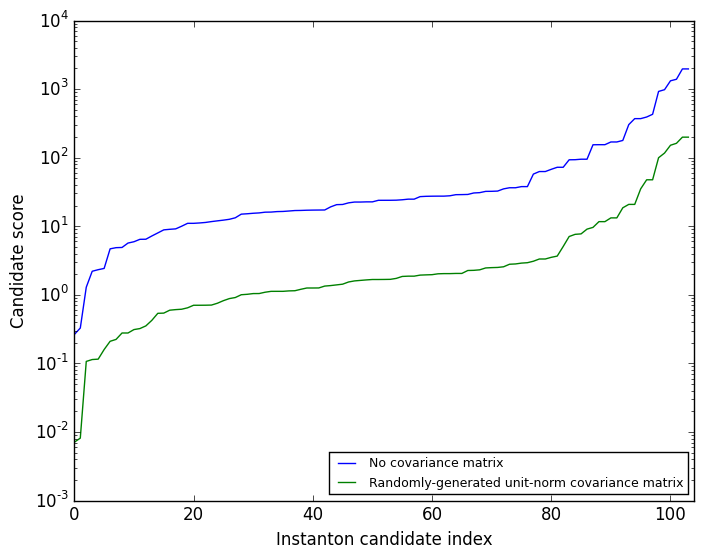

In [52]:
plot(sort(outputData_noCov.score))
hold(true)
plot(sort(outputData.score))
yscale("log")
xlim([0;104])
xlabel("Instanton candidate index")
ylabel("Candidate score")
legend(["No covariance matrix";"Randomly-generated unit-norm covariance matrix"],fontsize=9,loc=4)

savefig("../images/2015-08-11-score-by-covariance.svg")